In [42]:
# first we need a bit of import boilerplate
import os
import pickle as pkl
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from pathlib import Path
import json
from IPython.display import display
from PIL import Image
from tqdm import tqdm
from neo import SpikeTrain
import quantities as pq
import warnings
from elephant.gpfa import GPFA
from sklearn.model_selection import cross_val_score

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)
import copulagp.vine as v
import copulagp
import torch
import pickle as pkl

/var/folders/x1/kctky5lj58xftczlyf92pxcc0000gn/T/ipykernel_40053/3526284382.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [43]:
with open('../models/results/random_traj_13_res.pkl', 'rb') as f:
    rand_results = pkl.load(f)
rand_results['models']


[[<copulagp.bvcopula.models.Pair_CopulaGP_data at 0x17d1b4e10>,

In [44]:
len(rand_results['models'])

12

In [45]:
with open('../data/pupil_vine_data_0.pkl', 'rb') as f:
    data = pkl.load(f)
data

{'Y': array([[0.55344658, 0.66908739, 0.61822324, ..., 0.53443506, 0.75353204,
         0.45383817],
        [0.46482054, 0.44863733, 0.7178067 , ..., 0.49643576, 0.79524324,
         0.48237968],
        [0.43618047, 0.2354828 , 0.80789762, ..., 0.46726142, 0.82417159,
         0.50242089],
        ...,
        [0.21821657, 0.46146727, 0.39116084, ..., 0.57704394, 0.48466185,
         0.30895349],
        [0.2110881 , 0.41398531, 0.45020841, ..., 0.58643486, 0.4874351 ,
         0.30813931],
        [0.20295295, 0.3432269 , 0.52855117, ..., 0.5946485 , 0.4864187 ,
         0.30426715]]),
 'X': array([0.51168757, 0.51168757, 0.51188534, ..., 0.53875104, 0.53962348,
        0.54091954])}

Text(0.5, 1.08, 'Low Level Copula: Parameterized in Random Values (i.e. Unparameterized)')

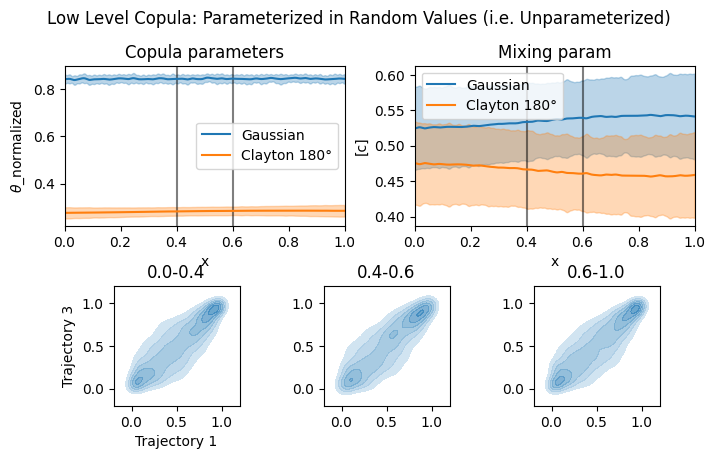

In [64]:
from copulagp.utils import Plot_Fit
try:
    Plot_Fit(
        rand_results['models'][0][1].model_init(torch.device('cpu')),
        np.random.random(*data['X'].shape),
        data['Y'],
        'Trajectory 1',
        'Trajectory 3',
        torch.device('cpu')
        )
except TypeError:
    pass
plt.suptitle('Low Level Copula: Parameterized in Random Values (i.e. Unparameterized)',y=1.08)

In [48]:
with open('../models/results/pupil_traj_13_res.pkl', 'rb') as f:
    pupil_results = pkl.load(f)
pupil_results['models']


[[<copulagp.bvcopula.models.Pair_CopulaGP_data at 0x17c0e5390>,

Text(0.5, 1.08, 'Low Level Copula: Parameterized in Pupil Dilation Robust Normalized per Trial')

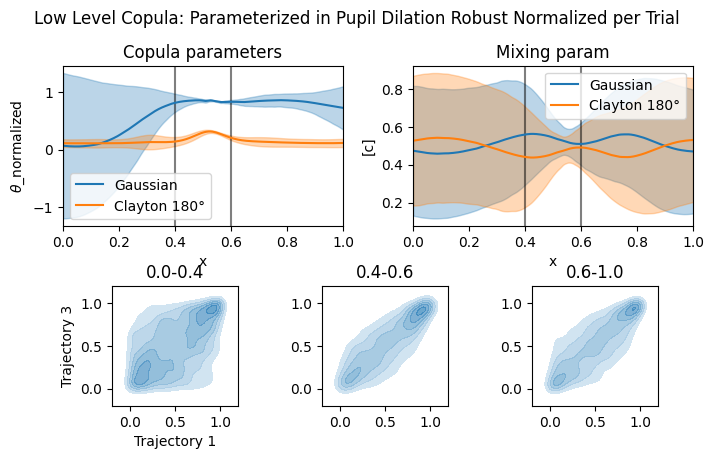

In [54]:
from copulagp.utils import Plot_Fit
try:
    Plot_Fit(
        pupil_results['models'][0][1].model_init(torch.device('cpu')),
        data['X'],
        data['Y'],
        'Trajectory 1',
        'Trajectory 3',
        torch.device('cpu')
        )
except TypeError:
    pass
plt.suptitle('Low Level Copula: Parameterized in Pupil Dilation Robust Normalized per Trial',y=1.08)

In [80]:
import copy

model_data = copy.deepcopy(pupil_results['models'])

for i,layer in enumerate(model_data):
    for j,cop_data in enumerate(layer):
        cop = cop_data.model_init('cpu').marginalize(torch.Tensor(data['X'][:100]))
        model_data[i][j]=cop
vine = v.CVine(model_data,torch.arange(0,1,0.01))

In [90]:
vine_sample = np.array([vine.sample().numpy().T for i in range(100)]).mean(axis=0)
vine_sample.shape

(13, 100)

In [91]:
data['Y'].T[0].shape

(10000,)